# First Flood Risk Task

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

import numbers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_recall_curve

from sklearn import set_config
set_config(transform_output="pandas")

In [2]:
df = pd.read_csv("flood_tool/resources/postcodes_labelled_1.csv")

In [3]:
df.head()

,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded
0,OL9 7NS,390978,403269,Unsurveyed/Urban,130,Oldham,1,119100.0,False
1,WV13 2LR,396607,298083,Unsurveyed/Urban,130,Walsall,1,84200.0,False
2,LS12 1LZ,427859,432937,Unsurveyed/Urban,60,Leeds,1,134900.0,False
3,SK15 1TS,395560,397900,Unsurveyed/Urban,120,Tameside,1,170200.0,False
4,TS17 9NN,445771,515362,Unsurveyed/Urban,20,Stockton-on-Tees,1,190600.0,False


# Drop duplicates

In [4]:
df.duplicated().sum()

0

# Train/Test split

In [5]:
X = df.drop(columns = 'riskLabel')

In [6]:
y = df['riskLabel']

In [7]:
y.value_counts()

1     28124
6       691
8       484
7       182
4       163
5       115
9        65
3        61
10       58
2        57
Name: riskLabel, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

We can see there's a clear imbalance.

# EDA

## Step 1: Check for missing values

In [9]:
X_train.isnull().sum()

postcode                  0
easting                   0
northing                  0
soilType                  0
elevation                 0
localAuthority            0
medianPrice            2575
historicallyFlooded       0
dtype: int64

In [10]:
X_train.isnull().sum()/X_train.shape[0]*100

postcode                0.000000
easting                 0.000000
northing                0.000000
soilType                0.000000
elevation               0.000000
localAuthority          0.000000
medianPrice            10.729167
historicallyFlooded     0.000000
dtype: float64

We won't drop the `meanPrice` columns as there are less than 30% of missing values.

## Step 2: Separate numerical and categorial data

In [11]:
num_cols = X_train.select_dtypes(include = np.number).columns

In [12]:
cat_cols = X_train.select_dtypes(exclude = np.number).columns

## Step 3: Analyse numerical data

In [13]:
X_train[num_cols].describe()

,easting,northing,elevation,medianPrice
count,24000.000000,24000.000000,24000.000000,2.142500e+04
mean,452871.240625,397186.658333,78.433750,3.067618e+05
std,57995.639391,86967.815445,61.132834,8.147280e+05
min,356445.000000,232759.000000,0.000000,3.000000e+02
25%,416175.000000,320575.250000,30.000000,1.564000e+05
50%,436755.000000,390689.000000,70.000000,2.173000e+05
75%,462702.000000,438643.750000,120.000000,3.052000e+05
max,655208.000000,654693.000000,470.000000,4.684090e+07


We can see that there are no negative values. However, we can observe some outliers on elevation.

Let's analyse colinearity.

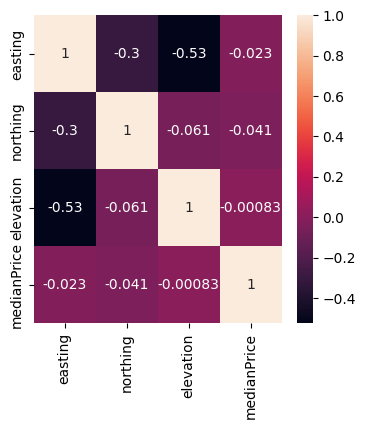

In [14]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
corr = X_train[num_cols].corr()
sns.heatmap(data=corr, annot=True, ax=ax);

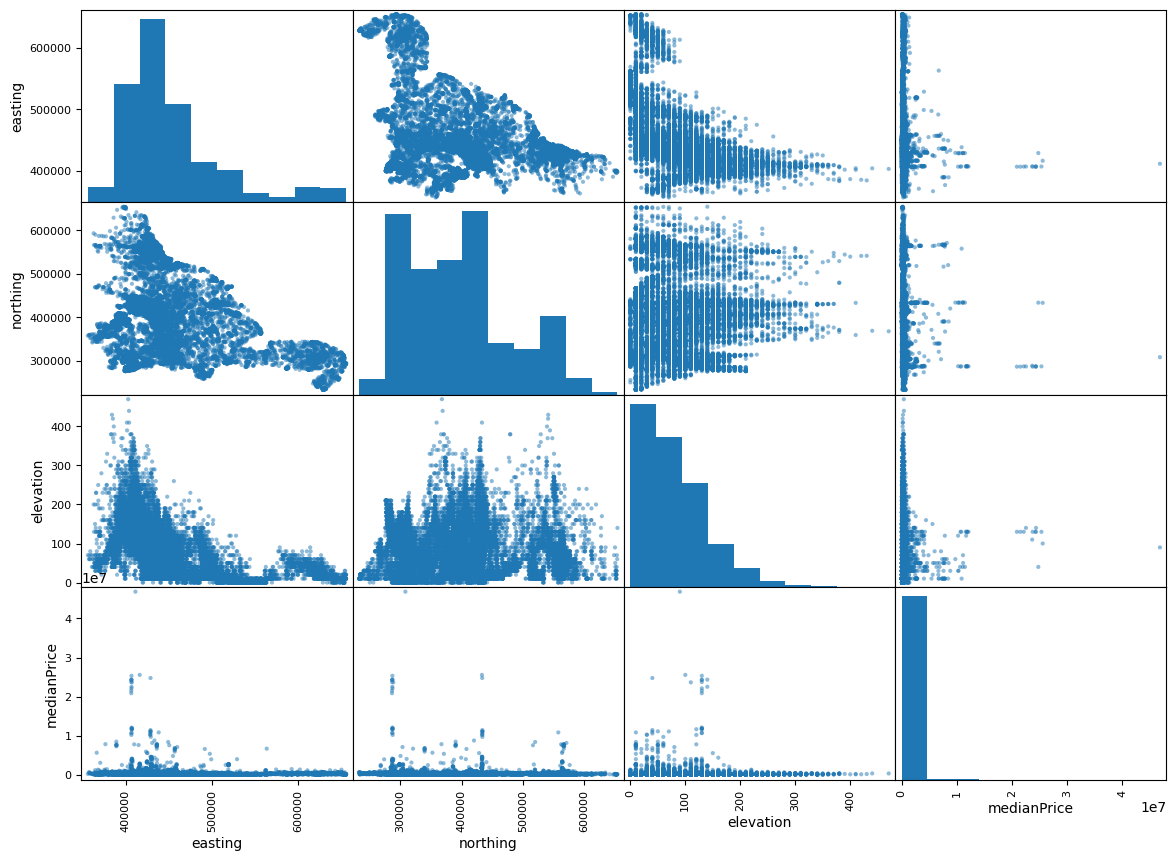

In [15]:
pd.plotting.scatter_matrix(X_train[num_cols], figsize=(14,10));

We cannot observe any direct correlation between the features.

In [16]:
num_cols = num_cols.drop('medianPrice') #We will keep same features as unlabelled data

## Step 5: Analyse categorical data

In [17]:
for feature in cat_cols:
    print(X_train[feature].value_counts())

YO3 3JG     1
BD5 8BE     1
WF9 5NB     1
DY7 6EY     1
OL1 3LS     1
           ..
LE5 9DY     1
HD8 1DB     1
SK17 7YG    1
LN11 8TJ    1
NR22 6BA    1
Name: postcode, Length: 24000, dtype: int64
Unsurveyed/Urban    15463
Stagnosols           2688
Cambisols            2235
Luvisols             1002
Gleysols              912
Arenosols             829
Planosols             428
Leptosols             308
Podsols                95
Histosols              40
Name: soilType, dtype: int64
Birmingham       1360
Leeds            1164
Bradford          791
County Durham     783
Sheffield         653
                 ... 
Tamworth           89
Boston             82
Bolsover           79
Melton             66
Rutland            58
Name: localAuthority, Length: 91, dtype: int64
False    23220
True       780
Name: historicallyFlooded, dtype: int64


We will drop `postcodes`, `localAuthority`, and `historicallyFlooded` because we have too many different values. If we OneHotEncode them we would end up with high cardinality

In [18]:
cat_cols = cat_cols.drop(['localAuthority', 'historicallyFlooded', 'postcode'])

## Step 5: Target variable

In [19]:
y_train.value_counts()

1     22494
6       549
8       390
7       146
4       133
5        91
2        54
9        53
10       47
3        43
Name: riskLabel, dtype: int64

We can see that it's really imbalance. So we will need to take this into account at the time of making predictions.

# Creating pipelines

Let's create a common preprocessing pipeline for all the methods

In [20]:
num_pipe = make_pipeline(SimpleImputer(), StandardScaler())

cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                         OneHotEncoder(handle_unknown='ignore', sparse_output = False))

preproc_pipe = ColumnTransformer([('num_cols', num_pipe, num_cols),
                                 ('cat_cols', cat_pipe, cat_cols)])

In [21]:
preproc_pipe.fit(X_train, y_train)

ColumnTransformer(transformers=[('num_cols',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['easting', 'northing', 'elevation'], dtype='object')),
                                ('cat_cols',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['soilType'], dtype='object'))])

In [22]:
X_train_prep = preproc_pipe.transform(X_train)

In [23]:
X_test_prep = preproc_pipe.transform(X_test)

# Model Selection and Tuning

We will be testing on the `scoring matrix`.

In [24]:
SCORES = np.array(
    [
        [100, 80, 60, 60, 30, 0, -30, -600, -1800, -2400],
        [80, 100, 80, 90, 60, 30, 0, -300, -1200, -1800],
        [60, 80, 100, 120, 90, 60, 30, 0, -600, -1200],
        [40, 60, 80, 150, 120, 90, 60, 300, 0, -600],
        [20, 40, 60, 120, 150, 120, 90, 600, 600, 0],
        [0, 20, 40, 90, 120, 150, 120, 900, 1200, 600],
        [-20, 0, 20, 60, 90, 120, 150, 1200, 1800, 1200],
        [-40, -20, 0, 30, 60, 90, 120, 1500, 2400, 1800],
        [-60, -40, -20, 0, 30, 60, 90, 1200, 3000, 2400],
        [-80, -60, -40, -30, 0, 30, 60, 900, 2400, 3000],
    ]
)

In [25]:
def score_fn(y_true: np.ndarray, y_pred: np.ndarray) -> numbers.Real:
     # Adjust for zero-based indexing
    y_pred_adjusted = np.round(y_pred, 0).astype(int) - 1
    y_true_adjusted = y_true - 1

    # Calculate the score
    score = sum(
        SCORES[pred, true] for pred, true in zip(y_pred_adjusted, y_true_adjusted)
    )
    return score

And we will create a custom scorer to tune our models taking into account the scoring matrix.

In [26]:
custom_scorer = make_scorer(score_fn, greater_is_better=True)

As the dataset is imbalanced we will try with and without smote.

## Classification models

### 1. LogisticRegression

In [27]:
logistic_reg_pipe = make_pipeline(preproc_pipe, LogisticRegression(max_iter=200))

In [28]:
logistic_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [29]:
y_lr_pred = logistic_reg_pipe.predict(X_test)

In [30]:
score_fn(y_test, y_lr_pred)

461360

### 2. LogisticRegression with SMOTE

In [31]:
smoted_pipe_lr = ImbPipeline([('preprocessor', preproc_pipe),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=600))])

In [32]:
smoted_pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=600))])

In [33]:
y_lr_smoted_pred = smoted_pipe_lr.predict(X_test)

In [34]:
score_fn(y_test, y_lr_smoted_pred)

324780

In this case we can see that `SMOTE` make results worse

### 3. KNN Classifier

In [35]:
knn_class_pipe = make_pipeline(preproc_pipe, KNeighborsClassifier())

In [36]:
knn_class_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [37]:
y_pred_knn_class = knn_class_pipe.predict(X_test)

In [38]:
score_fn(y_test, y_pred_knn_class)

529590

### 4. KNN Classifier with SMOTE

In [39]:
smoted_pipe_knn_class = ImbPipeline([('preprocessor', preproc_pipe),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())])

In [40]:
smoted_pipe_knn_class.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', KNeighborsClassifier())])

In [41]:
y_pred_smoted_knn_class = smoted_pipe_knn_class.predict(X_test)

In [42]:
score_fn(y_test, y_pred_smoted_knn_class)

593590

Here we can see that `SMOTE` improves the result !!

### 5. RandomForestClassifier

In [43]:
rf_class_pipe = make_pipeline(preproc_pipe, RandomForestClassifier())

In [44]:
rf_class_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [45]:
y_pred_rf_class = rf_class_pipe.predict(X_test)

In [46]:
score_fn(y_test, y_pred_rf_class)

560940

### 6. RandomForestClassifier with SMOTE

In [47]:
rf_smote_pipeline = ImbPipeline([
    ('preprocessor', preproc_pipe),
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier())
])

In [48]:
rf_smote_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE()), ('classifier', RandomForestClassifier())])

In [49]:
y_pred_rf_class_smote = rf_smote_pipeline.predict(X_test)

In [50]:
score_fn(y_test, y_pred_rf_class_smote)

602480

For now this is the best model without tunning !

### 7. MLP Classifier

In [51]:
mlp_class_pipe = make_pipeline(preproc_pipe, MLPClassifier())

In [52]:
mlp_class_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('mlpclassifier', MLPClassifier())])

In [53]:
y_mlp_class = mlp_class_pipe.predict(X_test)

In [54]:
score_fn(y_test, y_mlp_class)

475360

### 8. MLP Classifier with SMOTE

In [55]:
mlp_class_pipe_smoted = ImbPipeline([
    ('preprocessor', preproc_pipe),
    ('smote', SMOTE()),
    ('classifier', MLPClassifier())
])

In [56]:
mlp_class_pipe_smoted.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE()), ('classifier', MLPClassifier())])

In [57]:
y_mlp_smote = mlp_class_pipe_smoted.predict(X_test)

In [58]:
score_fn(y_test, y_mlp_smote)

480200

### 9. XGB Classifier

In [59]:
xgbc_pipe = make_pipeline(preproc_pipe, XGBClassifier())

In [60]:
xgbc_pipe.fit(X_train, y_train -1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto', ...))])

In [61]:
y_pred_xgbc = xgbc_pipe.predict(X_test)

In [62]:
score_fn(y_test, y_pred_xgbc+1)

511450

### 10. XGB Classifier SMOTED

In [63]:
xgb_smoted = ImbPipeline([
    ('preprocessor', preproc_pipe),
    ('smote', SMOTE()),
    ('classifier',XGBClassifier())
])

In [64]:
xgb_smoted.fit(X_train, y_train -1 )

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unkn...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto', ...))])

In [65]:
y_pred_xgb_smoted_class = xgb_smoted.predict(X_test)

In [66]:
score_fn(y_test, y_pred_xgb_smoted_class + 1)

601170

## Regression models

### 1. LinearRegression

In [67]:
linear_reg_pipe = make_pipeline(preproc_pipe, LinearRegression())

In [68]:
linear_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('linearregression', LinearRegression())])

In [69]:
y_linear_pred = linear_reg_pipe.predict(X_test)

In [70]:
score_fn(y_test, y_linear_pred)

475660

### 2. LinearRegression with SMOTE

In [71]:
lreg_smoted = ImbPipeline([
    ('preprocessor', preproc_pipe),
    ('smote', SMOTE()),
    ('classifier',LinearRegression())
])

In [72]:
lreg_smoted.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE()), ('classifier', LinearRegression())])

In [73]:
y_lreg = lreg_smoted.predict(X_test)

In [74]:
score_fn(y_test, y_lreg)

249460

### 3. RandomForestRegressor

In [75]:
rf_reg_pipe = make_pipeline(preproc_pipe, RandomForestRegressor())

In [76]:
rf_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('randomforestregressor', RandomForestRegressor())])

In [77]:
y_rf_reg = rf_reg_pipe.predict(X_test)

In [78]:
score_fn(y_test, y_rf_reg)

568320

### 4. RandomForesRegressor with SMOTE

In [79]:
rf_reg_smoted = ImbPipeline([
    ('preprocessor', preproc_pipe),
    ('smote', SMOTE()),
    ('classifier',LinearRegression())
])

In [80]:
rf_reg_smoted.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE()), ('classifier', LinearRegression())])

In [81]:
y_rf_reg_smoted = rf_reg_smoted.predict(X_test)

In [82]:
score_fn(y_test, y_rf_reg_smoted)

248430

### 5. MLP Regressor

In [83]:
mlp_reg = make_pipeline(preproc_pipe, MLPRegressor())

In [84]:
mlp_reg.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('mlpregressor', MLPRegressor())])

In [85]:
y_mlp_reg = mlp_reg.predict(X_test)

In [86]:
score_fn(y_test, y_mlp_reg)

507360

### 6. MLP Regressor with SMOTE

In [91]:
mlp_reg_smoted = ImbPipeline([
    ('preprocessor', preproc_pipe),
    ('smote', SMOTE()),
    ('classifier',MLPRegressor())
])

In [92]:
mlp_reg_smoted.fit(X_train, y_train-1)

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE()), ('classifier', MLPRegressor())])

In [93]:
y_mlp_reg_smoted = mlp_reg_smoted.predict(X_test)

In [94]:
score_fn(y_test, y_mlp_reg_smoted+1)

IndexError: index 10 is out of bounds for axis 0 with size 10

### 7. XGB Regressor

In [95]:
xgb_reg = make_pipeline(preproc_pipe, XGBRegressor())

In [96]:
xgb_reg.fit(X_train, y_train -1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [97]:
y_xgb_reg = xgb_reg.predict(X_test)

In [98]:
score_fn(y_test, y_xgb_reg +1)

539640

### 8. XGB Regressor with SMOTE

In [99]:
xgb_reg_smoted = ImbPipeline([
    ('preprocessor', preproc_pipe),
    ('smote', SMOTE()),
    ('classifier',XGBRegressor())
])

In [100]:
xgb_reg_smoted.fit(X_train, y_train -1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unkn...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [101]:
y_xgb_reg_pred = xgb_reg_smoted.predict(X_test)

In [102]:
score_fn(y_test, y_xgb_reg_pred + 1)

463020

# Trying to modify the loss functions on Regression algorithms

We will take the following approach.

In the metric evaluation grid we can see that it is more penalised when our model predicts a low risk flood, when in reality it was a high risk one.

So we will customise a loss function for the linear regression, so that it penalises more this case than the other, for example the following:

$$
\text{loss} =
\begin{cases} 
0.1 \times x^2 & \text{if } \text{difference} < 0 \\
x^2 & \text{otherwise}
\end{cases}
$$

where

$$
\text{difference} = y_{\text{true}} - y_{\text{pred}}
$$

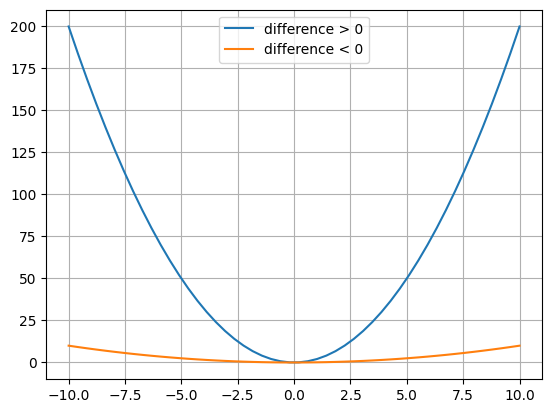

In [103]:
x = np.linspace(-10, 10)


plt.plot(x, 2*x**2, label='difference > 0')
plt.plot(x, 0.1*x**2, label='difference < 0')
plt.grid()
plt.legend()

In this way we will be penalising more understimations than overstimations.

## SGDRegressor modified

In [104]:
class CustomSGDRegressor:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.intercept = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.intercept = 0

        for _ in range(self.n_iterations):
            for i in range(n_samples):
                y_pred = np.dot(X[i], self.weights) + self.intercept
                difference = y[i] - y_pred

                if difference < 0:
                    # Gradient for underestimation
                    grad_weight = -0.2 * difference * X[i]
                    grad_intercept = -0.2 * difference
                else:
                    # Gradient for overestimation or correct estimation
                    grad_weight = -2 * difference * X[i]
                    grad_intercept = -2 * difference

                # Update weights and intercept
                self.weights -= self.learning_rate * grad_weight
                self.intercept -= self.learning_rate * grad_intercept

    def predict(self, X):
        return np.dot(X, self.weights) + self.intercept

In [105]:
sgd_custom = CustomSGDRegressor()

In [106]:
X_train_prep_np = X_train_prep.to_numpy()
y_train_np = y_train.to_numpy()
sgd_custom.fit(X_train_prep_np, y_train_np)

In [107]:
X_test_prep_np = X_test_prep.to_numpy()
y_test_np = y_test.to_numpy()

In [108]:
y_pred_sgd_custom = sgd_custom.predict(X_test_prep_np)

In [109]:
y_pred_final = np.round(y_pred_sgd_custom)

In [110]:
np.unique(y_pred_final)

array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])

## SGDRegressor modified by inheritance

In [114]:
from sklearn.linear_model import SGDRegressor

In [115]:
class CustomSGDRegressor(SGDRegressor):
    def _loss_function(self, coef, X, y, alpha, sample_weight):
        # Compute the predictions
        y_pred = safe_sparse_dot(X, coef)

        # Compute the difference between the true and predicted values
        difference = y - y_pred

        # Apply the custom loss function
        loss = np.where(difference < 0, 0.1 * difference ** 2, difference ** 2)

        # Apply sample weights and take the mean
        loss = np.average(loss, weights=sample_weight)

        # Add the regularization term
        loss += alpha * np.dot(coef, coef) / 2

        return loss

    def _gradient(self, coef, X, y, alpha, sample_weight):
        # Compute the predictions
        y_pred = safe_sparse_dot(X, coef)

        # Compute the difference
        difference = y - y_pred

        # Compute the gradient of the loss function
        grad = np.where(difference < 0, -0.2 * difference, -2 * difference)

        # Apply sample weights
        grad = np.average(grad[:, np.newaxis] * X, axis=0, weights=sample_weight)

        # Add the gradient of the regularization term
        grad += alpha * coef

        return grad

In [116]:
custom_sgd_regressor = CustomSGDRegressor()

In [117]:
custom_sgd_regressor.fit(X_train_prep, y_train)

CustomSGDRegressor()

In [118]:
y_pred_new = custom_sgd_regressor.predict(X_test_prep)

In [119]:
y_pred_new_rounded = np.round(y_pred_new)

In [120]:
np.unique(y_pred_new_rounded)

array([0., 1., 2., 3.])

# Pinball SGDRegressor

The `PinballSGDRegressor` extends `SGDRegressor` and modifies the loss function to implement the pinball loss, suitable for quantile regression. The pinball loss function is defined as:

$$
L(\tau, y, y_{\text{pred}}) = 
\begin{cases} 
\tau \cdot (y - y_{\text{pred}}) & \text{if } (y - y_{\text{pred}}) \geq 0 \\
(1 - \tau) \cdot (y_{\text{pred}} - y) & \text{otherwise}
\end{cases}
$$

where:

- $y$ is the true value.
- $y_{\text{pred}}$ is the predicted value.
- $\tau$ is the quantile.

The loss is then averaged over all samples, and a regularization term is added:

$$
\text{Total Loss} = \text{Average}(L(\tau, y, y_{\text{pred}})) + \frac{\alpha}{2} \cdot ||\text{coef}||^2
$$

- $\alpha$ is the regularization term.
- $\text{coef}$ represents the model coefficients.

In [121]:
class PinballSGDRegressor(SGDRegressor):
    def __init__(self, tau=0.5, penalty=None, alpha=0.0001, l1_ratio=0.15,
                 fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1,
                 random_state=None, learning_rate="invscaling", eta0=0.01, power_t=0.25,
                 early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, warm_start=False,
                 average=False):
        # Store the tau parameter
        self.tau = tau

        # Call the constructor of the parent class (SGDRegressor) without the 'loss' parameter
        super().__init__(penalty=penalty, alpha=alpha, l1_ratio=l1_ratio,
                         fit_intercept=fit_intercept, max_iter=max_iter, tol=tol, shuffle=shuffle,
                         verbose=verbose, epsilon=epsilon, random_state=random_state,
                         learning_rate=learning_rate, eta0=eta0, power_t=power_t,
                         early_stopping=early_stopping, validation_fraction=validation_fraction,
                         n_iter_no_change=n_iter_no_change, warm_start=warm_start, average=average)

    def _loss_function(self, coef, X, y, alpha, sample_weight):
        # Compute the predictions
        y_pred = safe_sparse_dot(X, coef)

        # Compute the difference
        difference = y - y_pred

        # Apply the pinball loss function
        loss = np.where(difference >= 0, self.tau * difference, (1 - self.tau) * -difference)

        # Apply sample weights and take the mean
        loss = np.average(loss, weights=sample_weight)

        # Add the regularization term
        loss += alpha * np.dot(coef, coef) / 2

        return loss

    def _gradient(self, coef, X, y, alpha, sample_weight):
        # Compute the predictions
        y_pred = safe_sparse_dot(X, coef)

        # Compute the difference
        difference = y - y_pred

        # Compute the gradient of the loss function
        grad = np.where(difference >= 0, -self.tau, self.tau - 1)

        # Apply sample weights
        grad = np.average(grad[:, np.newaxis] * X, axis=0, weights=sample_weight)

        # Add the gradient of the regularization term
        grad += alpha * coef

        return grad

# Example usage
# Create an instance of the pinball SGD regressor with a specific tau value
pinball_sgd_regressor = PinballSGDRegressor(tau=0.5) 

In [122]:
pinball_sgd_regressor = PinballSGDRegressor(tau=0.5)

In [123]:
pinball_sgd_regressor.fit(X_train_prep, y_train)

PinballSGDRegressor()

In [124]:
pinball_y = pinball_sgd_regressor.predict(X_test_prep)

In [125]:
pinball_y_rounded = np.round(pinball_y).astype(int)

In [126]:
pinball_y_rounded

array([1, 3, 1, ..., 1, 1, 1])

In [127]:
score_pinball = sum(
        [
            SCORES[_p - 1, _t - 1]
            for _p, _t in zip(pinball_y_rounded, y_test)
        ]
    )

In [128]:
score_pinball

474900

## Tunning models

Let's tune our best model, the `RandomForestClassifier()`

### RandomForestClassifier tuned

In [129]:
rf_pipe_2 = make_pipeline(preproc_pipe, RandomForestClassifier())

In [130]:
rf_pipe_2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [131]:
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [132]:
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_grid, cv=5, scoring=custom_scorer, verbose=1, n_jobs=-1)

In [133]:
rf_grid_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(score_fn), verbose=1)

In [134]:
print("Best parameters:", rf_grid_search.best_params_)
print("Best score:", rf_grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 443004.0


In [135]:
rf_pipe_tuned = make_pipeline(preproc_pipe, RandomForestClassifier(max_depth = 30, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100))

In [136]:
rf_pipe_tuned.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, max_features='log2'))])

In [137]:
y_rf_tuned = rf_pipe_tuned.predict(X_test)

In [138]:
score_fn(y_test, y_rf_tuned)

568820

# Trying threshold tunning

In [139]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# Categorical features pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),  # Replace with your numerical features
    ('cat', cat_pipe, cat_cols)  # Replace with your categorical features
])

# Final pipeline with SMOTE and the classifier
final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier())
])

In [140]:
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE()), ('classifier', RandomForestClassifier())])

In [141]:
final_pipeline.fit(X_train ,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('smote', SMOTE()), ('classifier', RandomForestClassifier())])

In [142]:
y_pred_rf_smoted = final_pipeline.predict(X_test)

In [143]:
score_fn(y_test, y_pred_rf_smoted)

600880

In [144]:
predictions_proba_baseline = final_pipeline.predict_proba(X_train)
predictions_baseline = final_pipeline.predict(X_train)

In [145]:
predictions_proba_baseline

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.71, 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.82, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [146]:
predictions_baseline

array([1, 1, 1, ..., 1, 1, 1])

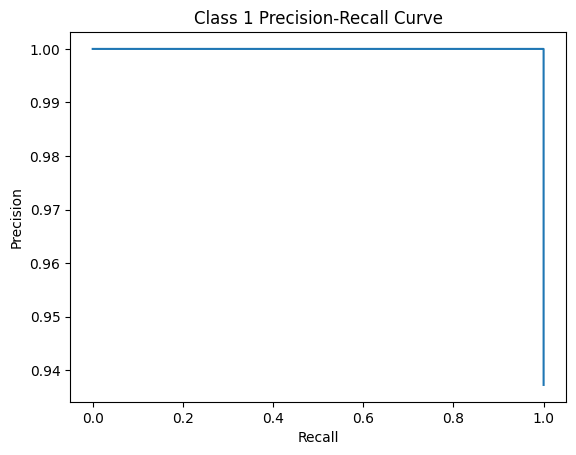

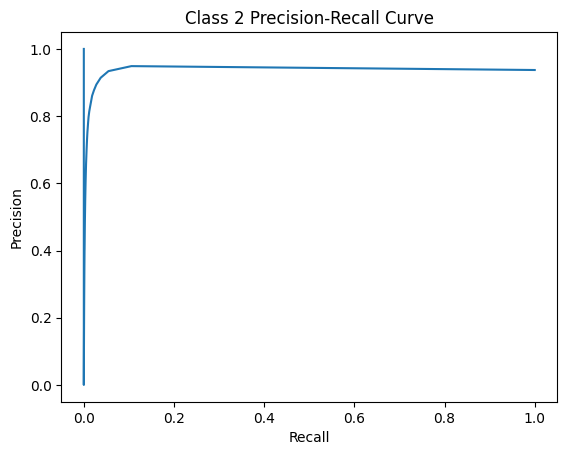

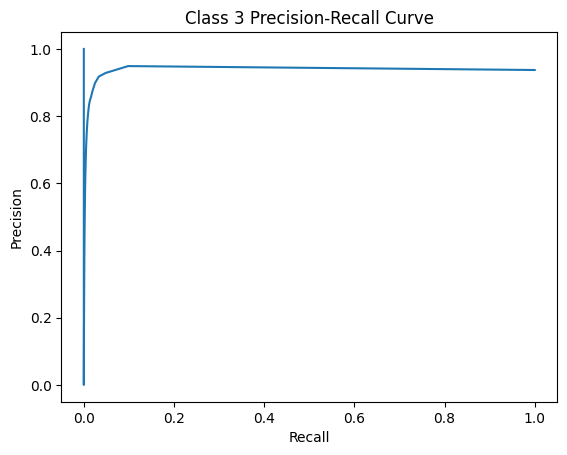

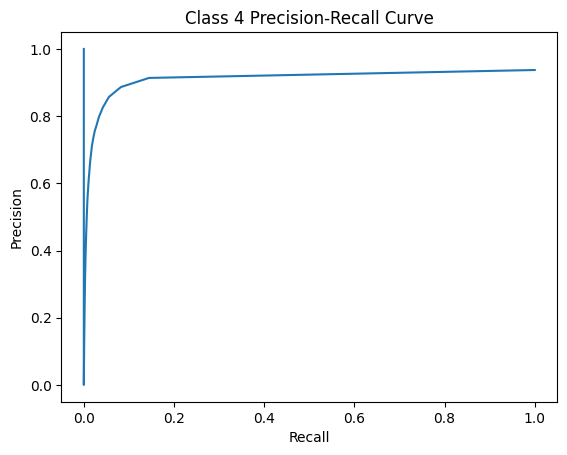

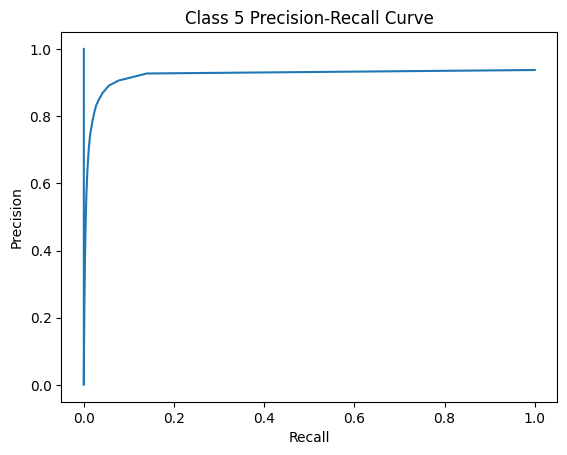

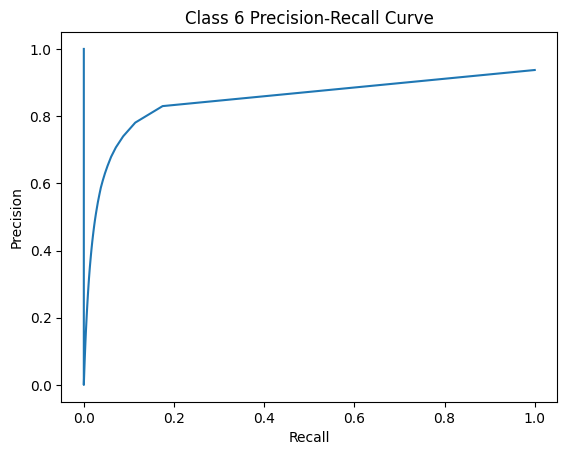

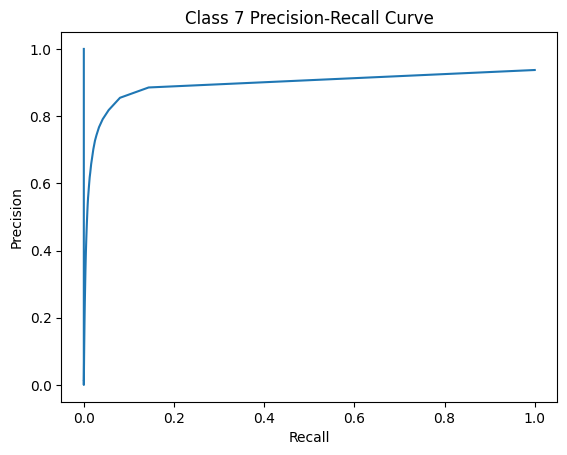

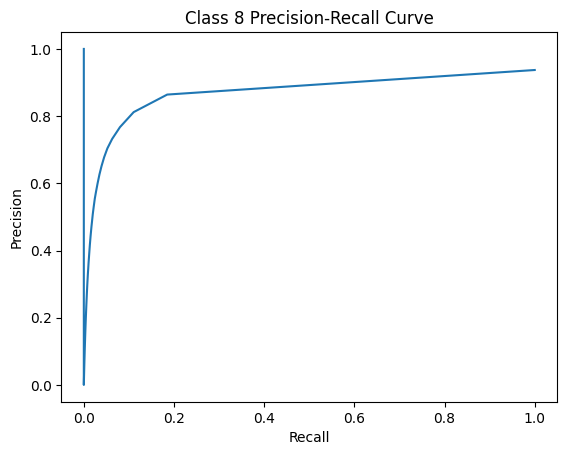

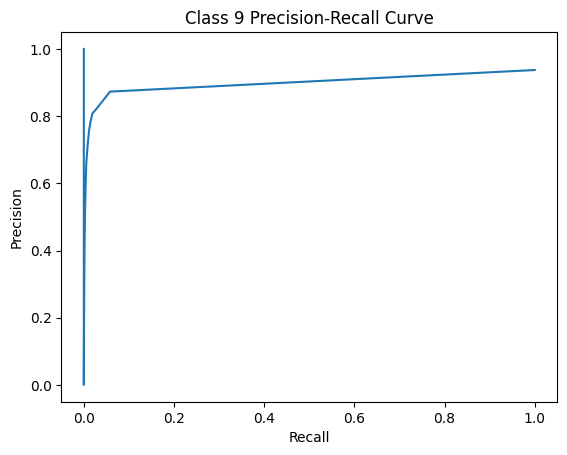

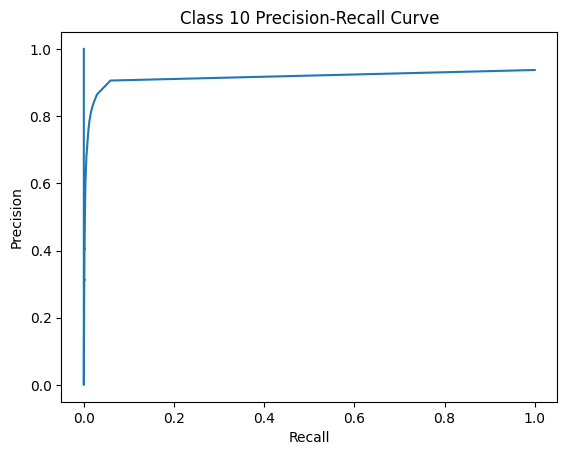

In [149]:
for i in range(10):
    precision_bl, recall_bl, threshold_bl = precision_recall_curve(y_train, predictions_proba_baseline[:,i],pos_label=1)
    plt.plot(recall_bl, precision_bl)
    plt.title(f'Class {i+1} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [150]:
prec_recall_bl_df = pd.DataFrame({'threshold':threshold_bl,
              'precision':precision_bl[:-1],
             'recall':recall_bl[:-1]})

In [152]:
selected_recall_bl_df = prec_recall_bl_df[prec_recall_bl_df['recall']>=0.001].\
sort_values(by='recall', ascending=True).\
reset_index(drop=True)

selected_recall_bl_df

,threshold,precision,recall
0,0.28,0.315068,0.001022
1,0.27,0.310811,0.001022
2,0.26,0.346154,0.001200
3,0.25,0.378049,0.001378
4,0.24,0.400000,0.001512
5,0.23,0.406977,0.001556
6,0.22,0.404494,0.001600
7,0.21,0.454545,0.002001
8,0.20,0.500000,0.002401
9,0.19,0.513514,0.002534


Not easy for a multiclass